In [0]:
# import the libraries
import warnings
warnings.filterwarnings('ignore')

# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

# Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)

# Model selection / utilities
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV
)
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)




In [0]:
import os
import pandas as pd


current_path = os.getcwd()  
target_path = os.path.abspath(os.path.join(
    current_path,
    "../../../data/customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
))

# import our data from csv file
df = pd.read_csv(target_path)

# show two rows
df.head(2)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Let's first clarify the variables of our dataset:

customerID – Unique identifier for each customer.

gender – Customer’s gender (e.g., Male/Female).

SeniorCitizen – Indicates if the customer is a senior (1 = Yes, 0 = No).

Partner – Whether the customer has a spouse/partner.

Dependents – Whether the customer has dependents (children, etc.).

tenure – Number of months the customer has stayed with the company.

PhoneService – Whether the customer has phone service.

MultipleLines – Whether the customer has multiple phone lines.

InternetService – Type of internet service (DSL, Fiber, None).

OnlineSecurity – Whether the customer has online security add-on.

OnlineBackup – Whether the customer has online backup add-on.

DeviceProtection – Whether the customer has device protection add-on.

TechSupport – Whether the customer has tech support add-on.

StreamingTV – Whether the customer has streaming TV service.

StreamingMovies – Whether the customer has streaming movie service.

Contract – Customer’s contract type (Month-to-month, 1-year, 2-year).

PaperlessBilling – Whether the customer uses paperless billing.

PaymentMethod – Customer’s payment method (e.g., credit card, bank transfer).

MonthlyCharges – Amount charged to the customer each month.

TotalCharges – Total amount charged over the entire tenure.

Churn – Indicates if the customer left the service (Yes/No).


In [0]:
# explore the data
df.shape

(7043, 21)

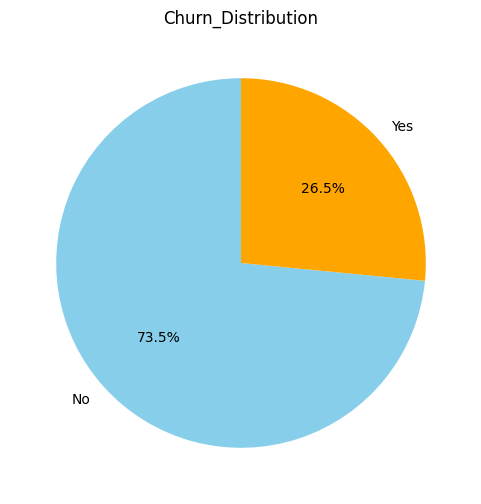

In [0]:
# Identifying the churn distribution between yes and no

# Count values
churn_count = df['Churn'].value_counts()

# Pie chart of churn value
plt.figure(figsize=(6,6))
plt.pie(churn_count, labels=churn_count.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Churn_Distribution')
plt.show()

In [0]:
# read some informstions about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [0]:
# missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Some necessary operations on variables:
1. Columns to Drop
These features are removed because they do not provide useful predictive information. They typically act as identifiers and only add noise to the dataset.

2. Target Variable
This represents the outcome the model is designed to predict. It serves as the reference point that guides how the algorithm learns patterns from the input features.

3. Boolean Columns
These features already exist in a binary numeric form, such as 0/1. Because of this, they require little to no preprocessing before being used in the model.

4. Columns to Convert to Boolean
These contain yes/no values stored as text and must be converted into binary form. Converting them ensures the model can interpret them correctly and uniformly.

5. Numerical Columns
These features contain measurable numeric values that often hold strong predictive importance. They may require scaling to keep their ranges consistent across the dataset.

6. Categorical Columns
These features contain text-based categories representing qualitative characteristics. They need to be encoded into numerical values so machine-learning algorithms can process them.

In [0]:
# 1 drop useless columns
df = df.drop(columns="customerID",axis=1)
df.shape

(7043, 20)

In [0]:
# there is other type of missing values
tenure_zero = (df['tenure'] == 0).sum()
print(tenure_zero)


11


In [0]:
# drop values where tenure is zero
df = df.drop(df[df['tenure'] == 0].index)
print((df['tenure'] == 0).sum())

0


In [0]:
# describe numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208
std,0.368844,24.545260,30.085974
min,0.000000,1.000000,18.250000
25%,0.000000,9.000000,35.587500
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.862500
max,1.000000,72.000000,118.750000


We noticed the absence of total charges and this is because the column has not numerical type

In [0]:
# Let's correct the column of total charges
# convert to numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df["TotalCharges"].mean())
df['TotalCharges'].isna().sum()


np.int64(0)

In [0]:
# check duplicated values
(df.duplicated()).sum()

np.int64(22)

In [0]:
# drop duplicated values
df.drop_duplicates(inplace=True)
(df.duplicated()).sum()

np.int64(0)

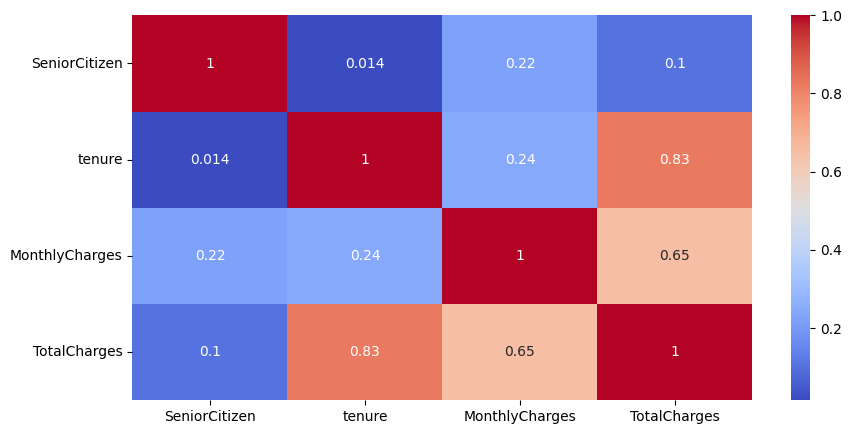

In [0]:
# corroleation between columns
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

Data Visualization

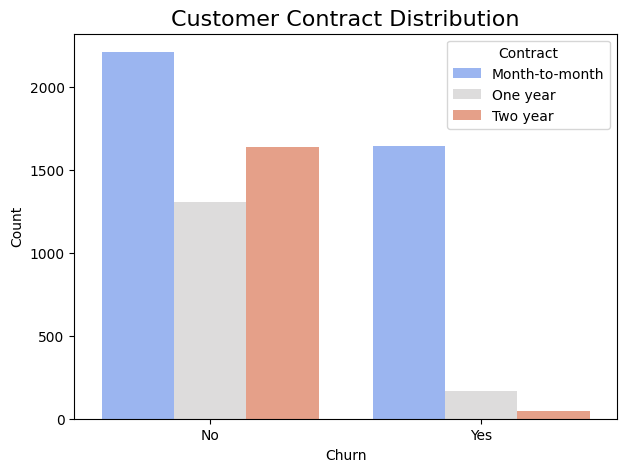

In [0]:
# Let's understand the churn distribution based on the contract type

# Set the figure size
plt.figure(figsize=(7, 5))

# Draw histogram with bars colored by 'Contract' type
sns.countplot(data=df,x="Churn", hue="Contract", palette="coolwarm"  )


# Add axis labels and title
plt.xlabel("Churn")
plt.ylabel("Count")
plt.title("Customer Contract Distribution", fontsize=16)
plt.legend(title="Contract")  # Legend title

# Display the plot
plt.show()


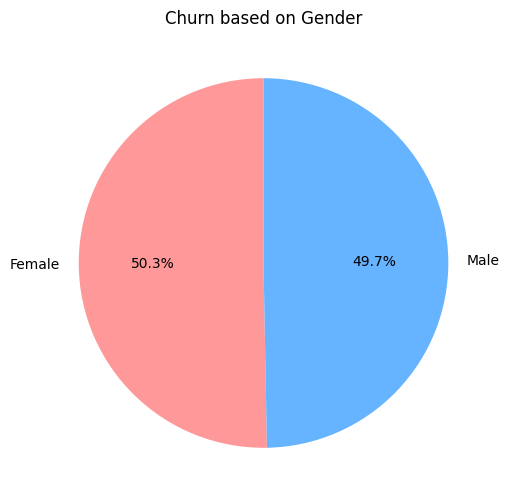

In [0]:
# understand churn based on gender
churn_gender = df[df["Churn"]=="Yes"].groupby("gender")["Churn"].count()

#  Pie chart
plt.figure(figsize=(6,6))
plt.pie(churn_gender, labels=churn_gender.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Churn based on Gender")
plt.show()



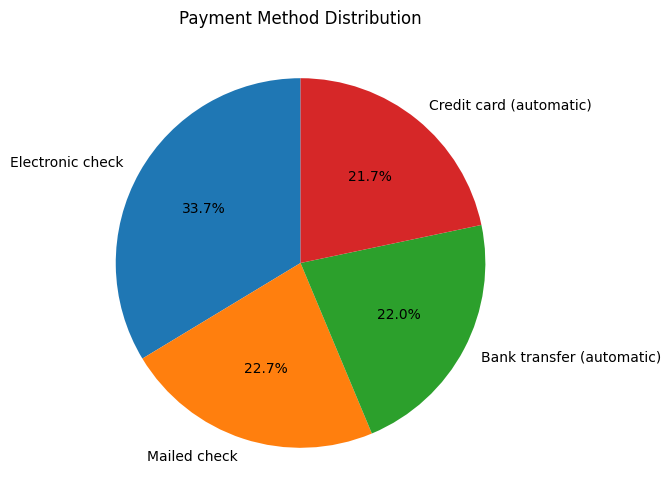

In [0]:
# comparing several types of payments
counts = df['PaymentMethod'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Payment Method Distribution")
plt.show()


In [0]:

# People with dependents are less likely to leave compared to those without dependents
fig = px.histogram(
    data_frame=df,
    x="Churn",
    color="Dependents",   
    barmode="group",
    width=700,
    height=500,
    title = "Dependents distribution"
    
)
fig.show()


People with dependents are less likely to leave compared to those without dependents

In [0]:
# compariing tenure 
fig = px.histogram(
    df,
    x="tenure",
    color="Churn",
    nbins=10,
    barmode="group",   
    color_discrete_map={"Yes": "red", "No": "blue"},
    title="Tenure by Churn",
    
)

fig.update_layout(
    xaxis_title="Tenure",
    yaxis_title="Frequency",
    template="simple_white"
)

fig.show()


In [0]:
# convert 0 and 1 to yes and no in senior citizen column
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})

fig = px.histogram(
    df,
    x="SeniorCitizen",
    color="Churn",
    barmode="group",
    title="Senior Citizen by Churn"
)

fig.update_layout(
    xaxis_title="Senior Citizen",
    yaxis_title="Frequency",
    template="simple_white"
)

fig.show()


In [0]:

# phone service
fig = px.histogram(
    df,
    x="PhoneService",
    color="Churn",
    barmode="group",
    title="PhoneService by Churn"
)

fig.update_layout(
    xaxis_title="Phone Service",
    yaxis_title="Frequency",
    template="simple_white"
)

fig.show()


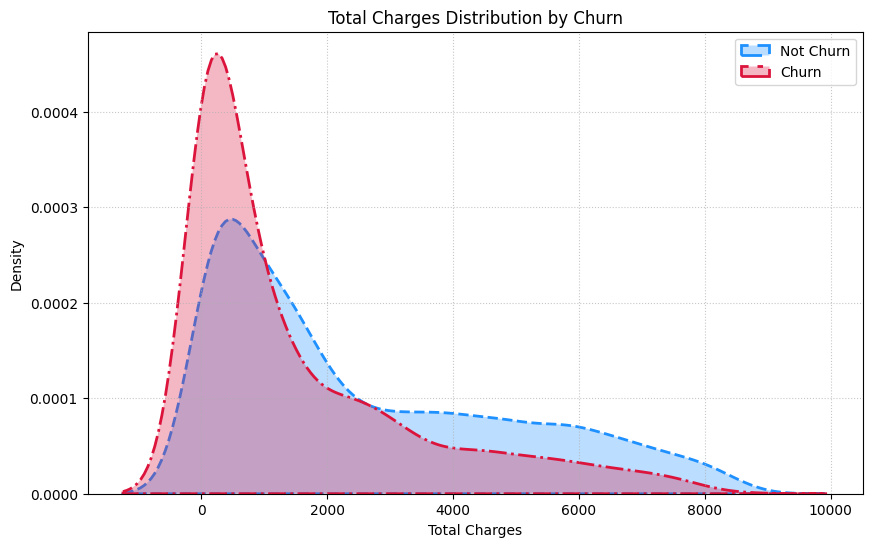

In [0]:
#kde plot of Totalcharges
plt.figure(figsize=(10,6))
ax = sns.kdeplot(
    data=df[df["Churn"] == 'No'], x="TotalCharges",
    color="DodgerBlue", fill=True, alpha=0.3, linewidth=2, linestyle='--'
)
ax = sns.kdeplot(
    data=df[df["Churn"] == 'Yes'], x="TotalCharges",
    color="Crimson", fill=True, alpha=0.3, linewidth=2, linestyle='-.'
)

ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Total Charges Distribution by Churn')

ax.grid(True, linestyle=':', alpha=0.7)

plt.show()


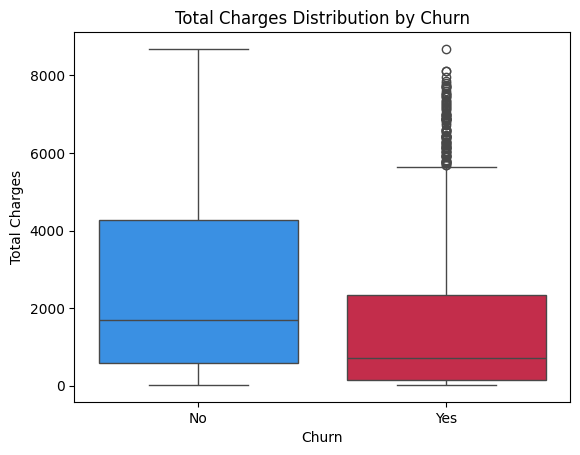

In [0]:
# box plot of total charges

sns.boxplot(x="Churn", y="TotalCharges", data=df, palette={"No":"DodgerBlue","Yes":"Crimson"})
plt.title("Total Charges Distribution by Churn")
plt.xlabel("Churn")
plt.ylabel("Total Charges")
plt.show()


In [0]:
# first we need to convert the target
df['Churn'] = df['Churn'].map({"No":0,"Yes":1})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [0]:
df['Churn'].unique()

array([0, 1])

In [0]:
# Separate target
y = df["Churn"]
X = df.drop("Churn", axis=1)

# One-hot encoding for all categorical features
X = pd.get_dummies(X, drop_first=False)

In [0]:
# TRAIN-TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [0]:
# PIPELINE (SCALER + MODEL)

pipeline = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsClassifier())
])

In [0]:
# grid search params
param_grid = [

    # ---- KNN ----
    {
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [3, 5, 7],
        "model__weights": ["uniform", "distance"]
    },

    # ---- SVC ----
    {
        "model": [SVC(probability=True)],
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"]
    },

    # ---- Random Forest ----
    {
        "model": [RandomForestClassifier()],
        "model__n_estimators": [100, 200],
        "model__max_depth": [5, 10, None]
    }
]


In [0]:
# model evaluation
grid = GridSearchCV(
    pipeline, param_grid,
    cv=5, scoring="accuracy", n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_



In [0]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8145506419400856

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      1081
           1       0.61      0.53      0.57       321

    accuracy                           0.81      1402
   macro avg       0.74      0.72      0.73      1402
weighted avg       0.81      0.81      0.81      1402

Confusion Matrix:
 [[971 110]
 [150 171]]


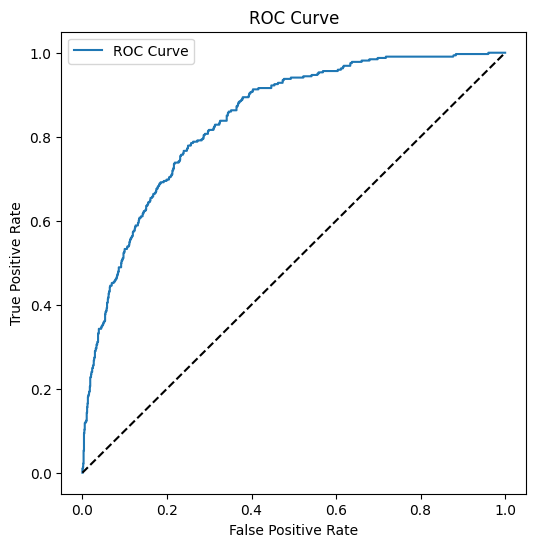

ROC AUC: 0.8419500231987803


In [0]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC:", roc_auc_score(y_test, y_prob))

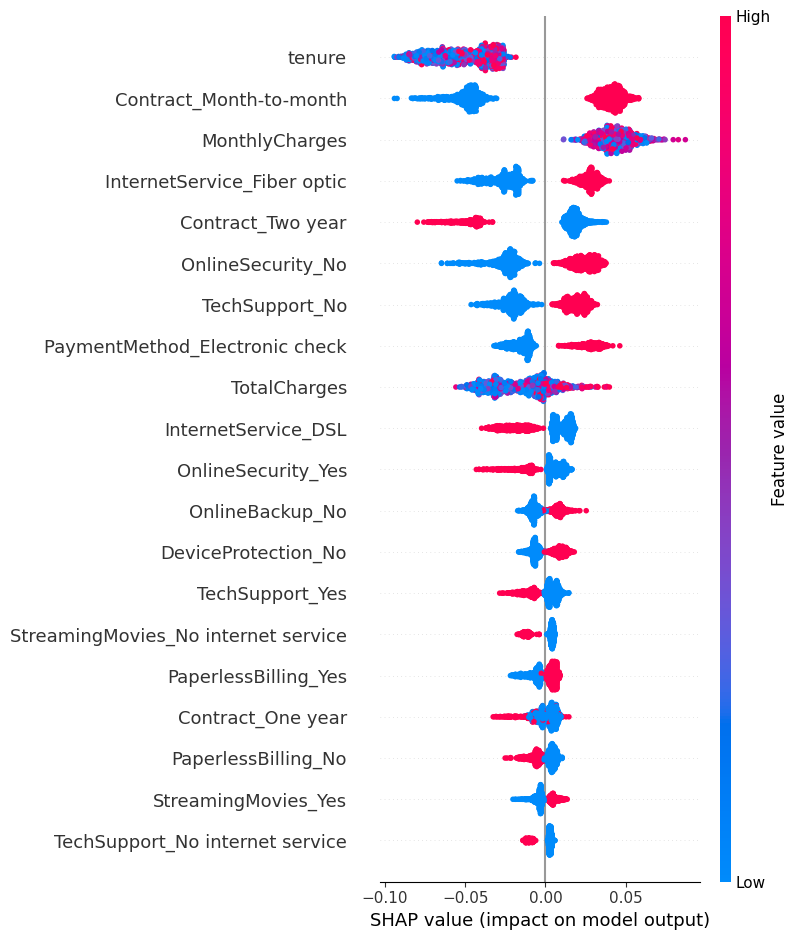

In [0]:
import shap
import matplotlib.pyplot as plt

# 1️⃣ Extract the trained RandomForest model
final_model = best_model.named_steps['model']

# 2️⃣ Align test columns with training columns
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

# 3️⃣ Create SHAP TreeExplainer
explainer = shap.TreeExplainer(final_model)

# 4️⃣ Calculate SHAP values
shap_values = explainer(X_test_aligned)  # use __call__ which returns a shap.Explanation object

# 5️⃣ Summary plot
# TreeExplainer now returns a shap.Explanation object; use .values for matrix
shap.summary_plot(shap_values.values[:, :, 1], X_test_aligned)

# 6️⃣ Force plot for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values.values[0, :, 1], X_test_aligned.iloc[0])


In [0]:
# save the model
import joblib
import pandas as pd

# Save the final model (Pipeline with Scaler + Model)
joblib.dump(best_model, "churn_model.pkl")
print("✅ Model saved as churn_model.pkl")

# Save the feature columns after One-Hot Encoding
joblib.dump(X_train.columns, "X_train_columns.pkl")
print("✅ Column names saved as X_train_columns.pkl")

✅ Model saved as churn_model.pkl
✅ Column names saved as X_train_columns.pkl


In [0]:
# =======================================
#  Model Deployment (API) with FastAPI
# =======================================
from fastapi import FastAPI
from pydantic import BaseModel

# Create FastAPI app
app = FastAPI(title="Customer Churn Prediction API")

# Load the saved model and columns
model = joblib.load("churn_model.pkl")
X_train_columns = joblib.load("X_train_columns.pkl")

# Define the data model for API input
class CustomerData(BaseModel):
    tenure: float
    MonthlyCharges: float
    TotalCharges: float
    gender_Female: int
    gender_Male: int
    SeniorCitizen_No: int
    SeniorCitizen_Yes: int
    Partner_No: int
    Partner_Yes: int
    Dependents_No: int
    Dependents_Yes: int
    PhoneService_No: int
    PhoneService_Yes: int
    MultipleLines_No: int
    MultipleLines_No_phone_service: int
    MultipleLines_Yes: int
    InternetService_DSL: int
    InternetService_Fiber_optic: int
    InternetService_No: int
    OnlineSecurity_No: int
    OnlineSecurity_No_internet_service: int
    OnlineSecurity_Yes: int
    OnlineBackup_No: int
    OnlineBackup_No_internet_service: int
    OnlineBackup_Yes: int
    DeviceProtection_No: int
    DeviceProtection_No_internet_service: int
    DeviceProtection_Yes: int
    TechSupport_No: int
    TechSupport_No_internet_service: int
    TechSupport_Yes: int
    StreamingTV_No: int
    StreamingTV_No_internet_service: int
    StreamingTV_Yes: int
    StreamingMovies_No: int
    StreamingMovies_No_internet_service: int
    StreamingMovies_Yes: int
    Contract_Month_to_month: int
    Contract_One_year: int
    Contract_Two_year: int
    PaperlessBilling_No: int
    PaperlessBilling_Yes: int
    PaymentMethod_Bank_transfer_automatic: int
    PaymentMethod_Credit_card_automatic: int
    PaymentMethod_Electronic_check: int
    PaymentMethod_Mailed_check: int

# Create prediction endpoint
@app.post("/predict")
def predict_churn(data: CustomerData):
    # Convert input data to DataFrame
    df = pd.DataFrame([data.dict()])
    
    # Align columns with the training set
    df_aligned = df.reindex(columns=X_train_columns, fill_value=0)
    
    # Predict probability and class
    pred_prob = model.predict_proba(df_aligned)[:, 1][0]
    pred_class = int(model.predict(df_aligned)[0])
    
    return {"Churn Probability": pred_prob, "Churn Prediction": pred_class}


# To run the API locally:
# uvicorn script_name:app --reload


In [0]:
# =======================================
#  User Interface / Dashboard (Optional)
# =======================================
import streamlit as st
import pandas as pd
import joblib

# Load saved model and columns
model = joblib.load("churn_model.pkl")
X_train_columns = joblib.load("X_train_columns.pkl")

st.title("Customer Churn Prediction Dashboard")
st.write("Enter customer data to predict churn probability and class.")

# Sidebar for customer input
st.sidebar.header("Customer Data Input")
input_data = {}

# Create inputs for all features
for col in X_train_columns:
    input_data[col] = st.sidebar.number_input(f"{col}", value=0)

# Predict button
if st.button("Predict Churn"):
    # Convert input to DataFrame
    df = pd.DataFrame([input_data])
    
    # Align columns with training columns
    df_aligned = df.reindex(columns=X_train_columns, fill_value=0)
    
    # Predict probability and class
    pred_prob = model.predict_proba(df_aligned)[:, 1][0]
    pred_class = int(model.predict(df_aligned)[0])
    
    # Display results
    st.subheader("Prediction Results")
    st.write(f"**Churn Probability:** {pred_prob:.2f}")
    st.write(f"**Churn Prediction:** {'Yes' if pred_class == 1 else 'No'}")


2025-12-11 15:45:59.352 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.414 
  command:

    streamlit run /databricks/python_shell/scripts/db_ipykernel_launcher.py [ARGUMENTS]
2025-12-11 15:45:59.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.416 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.416 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.417 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 15:45:59.417 Thread 'MainThread': missing S

In [0]:
%sh

streamlit run dashboard.py


Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: dashboard.py


In [0]:
# =======================================
# 1️⃣ Project Setup & Data Collection
# =======================================

# =======================================
# 2️⃣ Exploratory Data Analysis (EDA)
# =======================================

# =======================================
# 3️⃣ Data Cleaning & Preprocessing
# =======================================

# =======================================
# 4️⃣ Feature Engineering
# =======================================

# =======================================
# 5️⃣ Model Building & Training
# =======================================

# =======================================
# 6️⃣ Model Evaluation & Business Analysis
# =======================================

# =======================================
# 7️⃣ Model Explainability
# =======================================

# =======================================
# 8️⃣ Model Deployment (API)
# =======================================

# =======================================
# 9️⃣ User Interface / Dashboard (Optional)
# =======================================


